In [1]:
# import os
# os.listdir('../input')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, re
pd.set_option('display.max_columns',10000); pd.set_option('display.max_rows', 50); np.set_printoptions(threshold=90000)

import sys, os
sys.path.append('../../src/') #モジュールが入っているディレクトリのパスを指定

# import eda
# import config
import maprepro as mpre
import maprepro2 as mpre2



In [2]:
path='../../input/'
# a = pd.read_csv(f'{path}air_reserve.csv',)
asi = pd.read_csv(f'{path}air_store_info.csv',)
avd = pd.read_csv(f'{path}air_visit_data.csv',)
di = pd.read_csv(f'{path}date_info.csv',)
# a = pd.read_csv(f'{path}hpg_reserve.csv',)
# a = pd.read_csv(f'{path}hpg_store_info.csv',)
sa = pd.read_csv(f'{path}sample_submission.csv',)
# a = pd.read_csv(f'{path}store_id_relation.csv',)


In [3]:
'''
- 店ごとに日付ごとの平均を出すと同時にnanを作って0で補完

'''
avd.index = pd.to_datetime(avd['visit_date'])
# # 店ごとに特定の日に何人来たか
avd = avd.groupby('air_store_id').apply(lambda g: g['visitors'].resample('1d').mean()).reset_index()
# avd.query("air_store_id == 'air_00a91d42b08b08d9'" and "visit_date > '2016-07-01'" )
# filtered_df=df.query("Joined_date >= '2019-06-1' and Joined_date <='2020-02-05'")
avd['visit_date'] = avd['visit_date'].dt.strftime('%Y-%m-%d')
avd['was_nil'] = avd['visitors'].isnull()
avd['visitors'].fillna(0, inplace=True)

avd.head(1)
# avd.shape

,air_store_id,visit_date,visitors,was_nil
0,air_00a91d42b08b08d9,2016-07-01,35.0,False


In [4]:
# ラグ特徴量作成
date_info = pd.read_csv(f'{path}/date_info.csv')
date_info.rename(columns={'calendar_date': 'visit_date','holiday_flg': 'is_holiday'}, inplace=True)
date_info['prev_day_is_holiday'] = date_info['is_holiday'].shift().fillna(0)
date_info['next_day_is_holiday'] = date_info['is_holiday'].shift(-1).fillna(0)

date_info.head(1)
# date_info.shift()

,visit_date,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday
0,2016-01-01,Friday,1,0.0,1.0


In [5]:
'''
外れ値を適正値の中の最大値に置換
'''
def find_outliers(series):
    # 条件式なのでTrue,falseが返る
    return (series - series.mean()) > 2.4 * series.std()

def cap_values(series):
    outliers = find_outliers(series)
    max_val = series[~outliers].max()
    series[outliers] = max_val
    return series


stores = avd.groupby('air_store_id')
stores.apply(lambda g: find_outliers(g['visitors'])).values
avd['is_outlier'] = stores.apply(lambda g: find_outliers(g['visitors'])).values

avd['visitors_capped'] = stores.apply(lambda g: cap_values(g['visitors'])).values
avd['visitors_capped_log1p'] = np.log1p(avd['visitors_capped'])

# avd.query("visit_date > '2016-01-01'" and "visit_date < '2016-01-05'").head(20)

In [6]:
sa['air_store_id'] = sa['id'].str.slice(0, 20)
sa['visit_date'] = sa['id'].str.slice(21)
sa['is_test'] = True
sa['visitors'] = np.nan
sa['test_number'] = range(len(sa))
# sa

In [7]:
'''air_visit+sample_submission+date_info+air_store_info'''

data = pd.concat((avd, sa.drop('id', axis='columns')))
data['is_test'].fillna(False, inplace=True)
data = pd.merge(data, date_info, how='left', left_on=['visit_date'], right_on=['visit_date'])
data = pd.merge(left=data, right=asi, on='air_store_id', how='left')


In [8]:
data['visit_date'] = pd.to_datetime(data['visit_date'])
data.index = data['visit_date']

# astypeでtrue,false→1,0に変換できる
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)
data['day_of_month'] = data['visit_date'].dt.day
data['month_of_year'] = data['visit_date'].dt.month # 0815
data['dow'] = data['visit_date'].dt.dayofweek
data = pd.get_dummies(data, columns=['air_genre_name'])
# data = pd.get_dummies(data, columns=['day_of_week', 'air_genre_name'])


In [9]:
print(data.shape)
tr = data.query("is_test == False")
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])
tmp = tr.groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
data = pd.merge(data, tmp, how='left', on=['air_store_id', 'dow'])

print(data.shape)


(328298, 34)
(328298, 39)


In [10]:
'''
air_store_id
visit_date
test_number

is_holiday
prev_day_is_holiday
next_day_is_holiday

air_area_name

latitude
longitude

is_weekend
day_of_month
day_of_week_??
air_genre_name_??

識別フラグ
is_test
was_nil

visitors
is_outlier
visitors_capped
visitors_capped_log1p
'''
data.head(2)

,air_store_id,visit_date,visitors,was_nil,is_outlier,visitors_capped,visitors_capped_log1p,is_test,test_number,day_of_week,is_holiday,prev_day_is_holiday,next_day_is_holiday,air_area_name,latitude,longitude,is_weekend,day_of_month,month_of_year,dow,air_genre_name_Asian,air_genre_name_Bar/Cocktail,air_genre_name_Cafe/Sweets,air_genre_name_Creative cuisine,air_genre_name_Dining bar,air_genre_name_International cuisine,air_genre_name_Italian/French,air_genre_name_Izakaya,air_genre_name_Japanese food,air_genre_name_Karaoke/Party,air_genre_name_Okonomiyaki/Monja/Teppanyaki,air_genre_name_Other,air_genre_name_Western food,air_genre_name_Yakiniku/Korean food,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,2016-07-01,35.0,False,False,35.0,3.583519,False,NaN,Friday,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,0,1,7,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,33.953488,35.0,57.0,43
1,air_00a91d42b08b08d9,2016-07-02,9.0,False,False,9.0,2.302585,False,NaN,Saturday,0,0.0,0.0,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595,1,2,7,5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.0,13.232558,9.0,99.0,43


In [11]:
# data['visitors_log1p'] = np.log1p(data['visitors'])
train = data[(data['is_test'] == False) & (data['is_outlier'] == False) & (data['was_nil'] == False)]
test = data[data['is_test']].sort_values('test_number')

to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
           'is_outlier', 'visitors_capped', 'visitors', 'air_area_name','day_of_week']
        #    'visitors_capped_log1p']
# to_drop = ['air_store_id', 'is_test', 'test_number', 'visit_date', 'was_nil',
#            'is_outlier', 'visitors_capped', 'visitors', 'air_area_name',
#            'station_id', 'station_latitude', 'station_longitude', 'station_vincenty',
#            'station_great_circle', 'visitors_capped_log1p']
train = train.drop(to_drop, axis='columns')
train = train.dropna()
test = test.drop(to_drop, axis='columns')

# X_train = train.drop('visitors_log1p', axis='columns')
X_train = train.drop('visitors_capped_log1p', axis='columns')
X_test = test.drop('visitors_capped_log1p', axis='columns')
# X_test = test.drop('visitors_log1p', axis='columns')
# y_train = train['visitors_log1p']
y_train = train['visitors_capped_log1p']

In [12]:
import hashlib

class TunerCVCheckpointCallback(object):
    """Optuna の LightGBMTunerCV から学習済みモデルを取り出すためのコールバック"""

    def __init__(self):
        # オンメモリでモデルを記録しておく辞書
        self.cv_boosters = {}

    @staticmethod
    def params_to_hash(params):
        """パラメータを元に辞書のキーとなるハッシュを計算する"""
        # params_hash = hash((frozenset(params.items())))
        params_hash = hashlib.sha512(str(frozenset(params.items())).encode()).hexdigest()
        return params_hash

    def get_trained_model(self, params):
        """パラメータをキーとして学習済みモデルを取り出す"""
        params_hash = self.params_to_hash(params)
        return self.cv_boosters[params_hash]

    def __call__(self, env):
        """LightGBM の各ラウンドで呼ばれるコールバック"""
        # 学習に使うパラメータをハッシュ値に変換する
        params_hash = self.params_to_hash(env.params)
        # 初登場のパラメータならモデルへの参照を保持する
        if params_hash not in self.cv_boosters:
            self.cv_boosters[params_hash] = env.model
        # else:
        #     print(f'{params_hash}が衝突しました'*2)
        #     self.cv_boosters[params_hash] = env.model
    

In [14]:
from optuna.integration import lightgbm as lgb
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import lightgbm as lgbm
from sklearn import metrics
from sklearn import model_selection


np.random.seed(0)

# n_splits = 2

# val_scores = [0] * n_splits

sub = sa['id'].to_frame()
sub['visitors'] = 0

feature_importances = pd.DataFrame(index=X_train.columns)

# デモ用にデータセットを分割する
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    shuffle=True,
                                                    random_state=42)

lgb_train = lgb.Dataset(X_train, y_train)

# folds = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=0)

# 学習済みモデルへの参照を保持するためのコールバック
checkpoint_cb = TunerCVCheckpointCallback()
callbacks = [
    checkpoint_cb,
]

lgbm_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
}

tuner_cv = lgb.LightGBMTunerCV(
    lgbm_params, lgb_train,
    stratified = False,
    # num_boost_round=3,
    # early_stopping_rounds=1,
    # verbose_eval=20,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=200,
    # folds=folds,
    callbacks=callbacks,
)

tuner_cv.run()
# NOTE: 念のためハッシュの衝突に備えて Trial の数と学習済みモデルの数を比較しておく
assert len(checkpoint_cb.cv_boosters) == len(tuner_cv.study.trials)
# assert len(checkpoint_cb.cv_boosters) == len(tuner_cv.study.trials) - 1
    
# 最も良かったパラメータをキーにして学習済みモデルを取り出す
cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)
# Averaging でホールドアウト検証データを予測する
# y_pred_proba_list = cv_booster.predict(X_test,
#                                         num_iteration=cv_booster.best_iteration)
# y_pred_proba_avg = np.array(y_pred_proba_list).mean(axis=0)
# y_pred = np.where(y_pred_proba_avg > 0.5, 1, 0)

# sub['visitors'] /= n_splits
# sub['visitors'] = np.expm1(sub['visitors'])

# val_mean = np.mean(val_scores)
# val_std = np.std(val_scores)

# print('Local RMSLE: {:.5f} (±{:.5f})'.format(val_mean, val_std))


[I 2021-08-15 19:03:59,019] A new study created in memory with name: no-name-3400bd30-f428-4ec0-b763-3d9598f898fa


[200]	cv_agg's rmse: 0.497689 + 0.00138347
[400]	cv_agg's rmse: 0.496116 + 0.00131786
[600]	cv_agg's rmse: 0.4956 + 0.00140887
[800]	cv_agg's rmse: 0.495641 + 0.00125246


[I 2021-08-15 19:04:06,833] Trial 0 finished with value: 0.49545868633128265 and parameters: {'feature_fraction': 0.5}. Best is trial 0 with value: 0.49545868633128265.


[200]	cv_agg's rmse: 0.497305 + 0.00133325
[400]	cv_agg's rmse: 0.496177 + 0.00118793
[600]	cv_agg's rmse: 0.495858 + 0.00102426


[I 2021-08-15 19:04:12,443] Trial 1 finished with value: 0.4957914028458309 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.49545868633128265.


[200]	cv_agg's rmse: 0.497026 + 0.00134313
[400]	cv_agg's rmse: 0.495849 + 0.00125185
[600]	cv_agg's rmse: 0.495413 + 0.00131722


[I 2021-08-15 19:04:18,401] Trial 2 finished with value: 0.4954027334366934 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.4954027334366934.


[200]	cv_agg's rmse: 0.496896 + 0.0015781
[400]	cv_agg's rmse: 0.495891 + 0.00139237
[600]	cv_agg's rmse: 0.495539 + 0.00125602
[800]	cv_agg's rmse: 0.495576 + 0.00114772


[I 2021-08-15 19:04:25,550] Trial 3 finished with value: 0.49547791253690504 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.4954027334366934.


[200]	cv_agg's rmse: 0.49721 + 0.00144768
[400]	cv_agg's rmse: 0.495983 + 0.00121635
[600]	cv_agg's rmse: 0.495657 + 0.00120971


[I 2021-08-15 19:04:32,239] Trial 4 finished with value: 0.4955877802616146 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.4954027334366934.


[200]	cv_agg's rmse: 0.498083 + 0.00112663
[400]	cv_agg's rmse: 0.496572 + 0.00116924
[600]	cv_agg's rmse: 0.496112 + 0.00114741
[800]	cv_agg's rmse: 0.496068 + 0.0010491


[I 2021-08-15 19:04:40,431] Trial 5 finished with value: 0.4959832214594676 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.4954027334366934.


[200]	cv_agg's rmse: 0.497357 + 0.00130172
[400]	cv_agg's rmse: 0.49603 + 0.00136362
[600]	cv_agg's rmse: 0.495649 + 0.00148558
[800]	cv_agg's rmse: 0.495554 + 0.0014626


[I 2021-08-15 19:04:47,665] Trial 6 finished with value: 0.4954879587842969 and parameters: {'feature_fraction': 0.6}. Best is trial 2 with value: 0.4954027334366934.
feature_fraction, val_score: 0.495403: 100%|##########| 7/7 [00:48<00:00,  6.95s/it]


[200]	cv_agg's rmse: 0.497443 + 0.00106111
[400]	cv_agg's rmse: 0.496275 + 0.00104173
[600]	cv_agg's rmse: 0.495796 + 0.00117494
[800]	cv_agg's rmse: 0.495691 + 0.00106205


[I 2021-08-15 19:04:54,903] Trial 7 finished with value: 0.49563511309316055 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 0.49563511309316055.
[I 2021-08-15 19:05:01,704] Trial 8 finished with value: 0.4962547734655681 and parameters: {'num_leaves': 250}. Best is trial 7 with value: 0.49563511309316055.


[200]	cv_agg's rmse: 0.495946 + 0.000888734


[I 2021-08-15 19:05:07,340] Trial 9 finished with value: 0.4958402521183894 and parameters: {'num_leaves': 150}. Best is trial 7 with value: 0.49563511309316055.


[200]	cv_agg's rmse: 0.499279 + 0.00116506
[400]	cv_agg's rmse: 0.497624 + 0.00130402
[600]	cv_agg's rmse: 0.496606 + 0.00122364
[800]	cv_agg's rmse: 0.496106 + 0.0011189


[I 2021-08-15 19:05:12,925] Trial 10 finished with value: 0.49582705648594 and parameters: {'num_leaves': 13}. Best is trial 7 with value: 0.49563511309316055.


[1000]	cv_agg's rmse: 0.495844 + 0.00105971


[I 2021-08-15 19:05:18,859] Trial 11 finished with value: 0.4959672307954876 and parameters: {'num_leaves': 209}. Best is trial 7 with value: 0.49563511309316055.
[I 2021-08-15 19:05:26,463] Trial 12 finished with value: 0.4959158640289809 and parameters: {'num_leaves': 229}. Best is trial 7 with value: 0.49563511309316055.


[200]	cv_agg's rmse: 0.496875 + 0.00128084


[I 2021-08-15 19:05:33,262] Trial 13 finished with value: 0.4962547734655681 and parameters: {'num_leaves': 250}. Best is trial 7 with value: 0.49563511309316055.


[200]	cv_agg's rmse: 0.495431 + 0.00121728


[I 2021-08-15 19:05:38,341] Trial 14 finished with value: 0.4953994124835628 and parameters: {'num_leaves': 83}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.507034 + 0.00167852
[400]	cv_agg's rmse: 0.504668 + 0.00158528
[600]	cv_agg's rmse: 0.503682 + 0.00147398
[800]	cv_agg's rmse: 0.503079 + 0.00141128


[I 2021-08-15 19:05:42,198] Trial 15 finished with value: 0.5026374213526853 and parameters: {'num_leaves': 3}. Best is trial 14 with value: 0.4953994124835628.


[1000]	cv_agg's rmse: 0.502637 + 0.00139454
[200]	cv_agg's rmse: 0.496384 + 0.00120653


[I 2021-08-15 19:05:48,964] Trial 16 finished with value: 0.49583058129367485 and parameters: {'num_leaves': 193}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495656 + 0.00112463


[I 2021-08-15 19:05:55,019] Trial 17 finished with value: 0.4955873163767627 and parameters: {'num_leaves': 89}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495776 + 0.00125638


[I 2021-08-15 19:06:00,603] Trial 18 finished with value: 0.4957077664625144 and parameters: {'num_leaves': 94}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495645 + 0.00103316


[I 2021-08-15 19:06:07,097] Trial 19 finished with value: 0.4956318617313743 and parameters: {'num_leaves': 91}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495688 + 0.00141404


[I 2021-08-15 19:06:12,828] Trial 20 finished with value: 0.4954558861872841 and parameters: {'num_leaves': 68}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.496267 + 0.00139227
[400]	cv_agg's rmse: 0.495892 + 0.00131444


[I 2021-08-15 19:06:18,443] Trial 21 finished with value: 0.4958674555170813 and parameters: {'num_leaves': 52}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495874 + 0.00134025


[I 2021-08-15 19:06:24,440] Trial 22 finished with value: 0.4957479010685639 and parameters: {'num_leaves': 141}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.496301 + 0.00117976
[400]	cv_agg's rmse: 0.495997 + 0.00107369


[I 2021-08-15 19:06:29,485] Trial 23 finished with value: 0.4959229159584743 and parameters: {'num_leaves': 57}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495776 + 0.00102348


[I 2021-08-15 19:06:35,229] Trial 24 finished with value: 0.4956755537575438 and parameters: {'num_leaves': 125}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.496301 + 0.00117976
[400]	cv_agg's rmse: 0.495997 + 0.00107369


[I 2021-08-15 19:06:40,281] Trial 25 finished with value: 0.4959229159584743 and parameters: {'num_leaves': 57}. Best is trial 14 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.49552 + 0.00119143


[I 2021-08-15 19:06:45,687] Trial 26 finished with value: 0.49549467167344485 and parameters: {'num_leaves': 105}. Best is trial 14 with value: 0.4953994124835628.
num_leaves, val_score: 0.495399: 100%|##########| 20/20 [01:58<00:00,  5.90s/it]


[200]	cv_agg's rmse: 0.49566 + 0.00117375


[I 2021-08-15 19:06:52,781] Trial 27 finished with value: 0.495558088724913 and parameters: {'bagging_fraction': 0.9526045679668569, 'bagging_freq': 2}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.495643 + 0.00141489


[I 2021-08-15 19:06:58,197] Trial 28 finished with value: 0.4956242603991209 and parameters: {'bagging_fraction': 0.9817306923917962, 'bagging_freq': 3}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.497723 + 0.0010775


[I 2021-08-15 19:07:02,725] Trial 29 finished with value: 0.49738325843895126 and parameters: {'bagging_fraction': 0.6023450541205602, 'bagging_freq': 6}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.496338 + 0.00103947


[I 2021-08-15 19:07:09,956] Trial 30 finished with value: 0.4962724384395069 and parameters: {'bagging_fraction': 0.8397625943995125, 'bagging_freq': 5}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.498889 + 0.00121409


[I 2021-08-15 19:07:14,915] Trial 31 finished with value: 0.498224384319487 and parameters: {'bagging_fraction': 0.4440522598148, 'bagging_freq': 1}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.497273 + 0.00159463


[I 2021-08-15 19:07:19,876] Trial 32 finished with value: 0.49706274724541444 and parameters: {'bagging_fraction': 0.6051693264097657, 'bagging_freq': 2}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.497901 + 0.00132684


[I 2021-08-15 19:07:24,458] Trial 33 finished with value: 0.49750867620982453 and parameters: {'bagging_fraction': 0.5601615696296042, 'bagging_freq': 3}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.498241 + 0.00111315


[I 2021-08-15 19:07:28,948] Trial 34 finished with value: 0.4980870350583861 and parameters: {'bagging_fraction': 0.5480798602267677, 'bagging_freq': 6}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.496175 + 0.00147371


[I 2021-08-15 19:07:34,905] Trial 35 finished with value: 0.4961053123459843 and parameters: {'bagging_fraction': 0.8226079176921839, 'bagging_freq': 6}. Best is trial 27 with value: 0.495558088724913.


[200]	cv_agg's rmse: 0.49864 + 0.00115207


[I 2021-08-15 19:07:39,721] Trial 36 finished with value: 0.4981432004620617 and parameters: {'bagging_fraction': 0.47824373401251774, 'bagging_freq': 4}. Best is trial 27 with value: 0.495558088724913.
bagging, val_score: 0.495399: 100%|##########| 10/10 [00:54<00:00,  5.40s/it]


[200]	cv_agg's rmse: 0.495822 + 0.00114831


[I 2021-08-15 19:07:45,514] Trial 37 finished with value: 0.49568849392134695 and parameters: {'feature_fraction': 0.7200000000000001}. Best is trial 37 with value: 0.49568849392134695.


[200]	cv_agg's rmse: 0.495431 + 0.00121728


[I 2021-08-15 19:07:50,938] Trial 38 finished with value: 0.4953994124835628 and parameters: {'feature_fraction': 0.784}. Best is trial 38 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495567 + 0.00115241


[I 2021-08-15 19:07:58,368] Trial 39 finished with value: 0.49550741240729623 and parameters: {'feature_fraction': 0.8160000000000001}. Best is trial 38 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495629 + 0.00117588


[I 2021-08-15 19:08:03,264] Trial 40 finished with value: 0.49560658920759826 and parameters: {'feature_fraction': 0.88}. Best is trial 38 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495578 + 0.00117288


[I 2021-08-15 19:08:09,913] Trial 41 finished with value: 0.49552774435412345 and parameters: {'feature_fraction': 0.8480000000000001}. Best is trial 38 with value: 0.4953994124835628.


[200]	cv_agg's rmse: 0.495657 + 0.00143449


[I 2021-08-15 19:08:16,094] Trial 42 finished with value: 0.4955644560650246 and parameters: {'feature_fraction': 0.7520000000000001}. Best is trial 38 with value: 0.4953994124835628.
feature_fraction_stage2, val_score: 0.495399: 100%|##########| 6/6 [00:36<00:00,  6.06s/it]


[200]	cv_agg's rmse: 0.495452 + 0.0013276


[I 2021-08-15 19:08:21,381] Trial 43 finished with value: 0.4954029942927109 and parameters: {'lambda_l1': 1.5993078397916925e-06, 'lambda_l2': 2.009304313139623e-05}. Best is trial 43 with value: 0.4954029942927109.


[200]	cv_agg's rmse: 0.495455 + 0.00126765


[I 2021-08-15 19:08:26,559] Trial 44 finished with value: 0.4954218445875946 and parameters: {'lambda_l1': 4.059899641343562e-06, 'lambda_l2': 0.0021346036816444615}. Best is trial 43 with value: 0.4954029942927109.


[200]	cv_agg's rmse: 0.49531 + 0.00124702


[I 2021-08-15 19:08:32,598] Trial 45 finished with value: 0.49520916262208853 and parameters: {'lambda_l1': 2.7030883442863514e-07, 'lambda_l2': 0.0073295661456513955}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495766 + 0.00123582


[I 2021-08-15 19:08:38,962] Trial 46 finished with value: 0.4957206782733092 and parameters: {'lambda_l1': 1.083344874639692, 'lambda_l2': 0.4553657076502388}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495376 + 0.00135575


[I 2021-08-15 19:08:46,844] Trial 47 finished with value: 0.4953298089000759 and parameters: {'lambda_l1': 1.4309609787388362, 'lambda_l2': 2.3290369369825923e-06}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495655 + 0.00128272


[I 2021-08-15 19:08:54,031] Trial 48 finished with value: 0.4955344070226536 and parameters: {'lambda_l1': 0.0027664420025047707, 'lambda_l2': 3.0595137446685255e-07}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495747 + 0.00136135


[I 2021-08-15 19:09:01,399] Trial 49 finished with value: 0.49542043048999773 and parameters: {'lambda_l1': 0.01219993819485314, 'lambda_l2': 1.7446340549125377e-06}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495439 + 0.00122857
[400]	cv_agg's rmse: 0.495773 + 0.000986986


[I 2021-08-15 19:09:09,127] Trial 50 finished with value: 0.49538598333361905 and parameters: {'lambda_l1': 6.3407612293094036e-06, 'lambda_l2': 0.0053394522006468105}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495567 + 0.00116263


[I 2021-08-15 19:09:15,531] Trial 51 finished with value: 0.4953987418636519 and parameters: {'lambda_l1': 0.0012599981484908384, 'lambda_l2': 3.819281732213857e-07}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495546 + 0.00136111


[I 2021-08-15 19:09:21,973] Trial 52 finished with value: 0.4954688074094341 and parameters: {'lambda_l1': 6.006148946507219e-07, 'lambda_l2': 0.04756987153434126}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495557 + 0.00146663


[I 2021-08-15 19:09:28,315] Trial 53 finished with value: 0.4954560930927109 and parameters: {'lambda_l1': 1.1218131209830711e-08, 'lambda_l2': 0.00012238707170542248}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.496504 + 0.00109899
[400]	cv_agg's rmse: 0.496413 + 0.00113525


[I 2021-08-15 19:09:37,301] Trial 54 finished with value: 0.49631817461706157 and parameters: {'lambda_l1': 9.347986184044025, 'lambda_l2': 1.6088117547909253e-08}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495611 + 0.00121074


[I 2021-08-15 19:09:43,420] Trial 55 finished with value: 0.495460820877797 and parameters: {'lambda_l1': 0.13803247017855486, 'lambda_l2': 1.3070754036668986}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495779 + 0.00130408


[I 2021-08-15 19:09:48,493] Trial 56 finished with value: 0.4957752027644817 and parameters: {'lambda_l1': 0.00016798593212568496, 'lambda_l2': 3.946172526173302e-05}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495408 + 0.00133116


[I 2021-08-15 19:09:54,494] Trial 57 finished with value: 0.4953293198316741 and parameters: {'lambda_l1': 1.260173803741914e-08, 'lambda_l2': 0.0013752801323630584}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495271 + 0.00136801


[I 2021-08-15 19:10:00,700] Trial 58 finished with value: 0.4952308578613341 and parameters: {'lambda_l1': 1.1593812751683088e-08, 'lambda_l2': 0.0029027923622570147}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495586 + 0.00118761


[I 2021-08-15 19:10:06,027] Trial 59 finished with value: 0.4955847491623187 and parameters: {'lambda_l1': 1.3414826553558505e-07, 'lambda_l2': 0.034289001177901984}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495481 + 0.00144499


[I 2021-08-15 19:10:12,568] Trial 60 finished with value: 0.4954114727055581 and parameters: {'lambda_l1': 9.620330861402953e-05, 'lambda_l2': 0.0764975612489835}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.495505 + 0.00143469


[I 2021-08-15 19:10:17,795] Trial 61 finished with value: 0.4954742922554778 and parameters: {'lambda_l1': 6.996235053386921e-08, 'lambda_l2': 0.0004980750294972264}. Best is trial 45 with value: 0.49520916262208853.


[200]	cv_agg's rmse: 0.49577 + 0.00135394


[I 2021-08-15 19:10:22,848] Trial 62 finished with value: 0.49575230602817283 and parameters: {'lambda_l1': 2.997801783963654e-05, 'lambda_l2': 2.756284285691622}. Best is trial 45 with value: 0.49520916262208853.
regularization_factors, val_score: 0.495209: 100%|##########| 20/20 [02:06<00:00,  6.34s/it]


[200]	cv_agg's rmse: 0.495767 + 0.0014412


[I 2021-08-15 19:10:27,996] Trial 63 finished with value: 0.4957297975095081 and parameters: {'min_child_samples': 25}. Best is trial 63 with value: 0.4957297975095081.


[200]	cv_agg's rmse: 0.495743 + 0.00153031


[I 2021-08-15 19:10:34,054] Trial 64 finished with value: 0.4957006293371383 and parameters: {'min_child_samples': 50}. Best is trial 64 with value: 0.4957006293371383.


[200]	cv_agg's rmse: 0.495487 + 0.00158407


[I 2021-08-15 19:10:39,738] Trial 65 finished with value: 0.4953471665386705 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.4953471665386705.


[200]	cv_agg's rmse: 0.496171 + 0.00129776


[I 2021-08-15 19:10:44,851] Trial 66 finished with value: 0.49612625898004464 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.4953471665386705.


[200]	cv_agg's rmse: 0.496379 + 0.00153639


[I 2021-08-15 19:10:52,229] Trial 67 finished with value: 0.49621946153980157 and parameters: {'min_child_samples': 100}. Best is trial 65 with value: 0.4953471665386705.
min_data_in_leaf, val_score: 0.495209: 100%|##########| 5/5 [00:29<00:00,  5.88s/it]


AssertionError: 

In [15]:
best_params = tuner_cv.best_params
best_params

{'objective': 'regression',
 'metric': 'rmse',
 'verbosity': -1,
 'feature_pre_filter': False,
 'lambda_l1': 2.7030883442863514e-07,
 'lambda_l2': 0.0073295661456513955,
 'num_leaves': 83,
 'feature_fraction': 0.8,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [16]:
sub = sa['id'].to_frame()
sub['visitors'] = 0

X_train = train.drop('visitors_capped_log1p', axis='columns')
y_train = train['visitors_capped_log1p']
X_test = test.drop('visitors_capped_log1p', axis='columns')

model = lgbm.LGBMRegressor(**best_params)

model.fit(
    X_train,
    y_train,
    verbose=False
)

sub['visitors'] = model.predict(X_test)
sub['visitors'] = np.expm1(sub['visitors'])
sub


,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.789109
1,air_00a91d42b08b08d9_2017-04-24,19.223714
2,air_00a91d42b08b08d9_2017-04-25,25.125930
3,air_00a91d42b08b08d9_2017-04-26,28.245374
4,air_00a91d42b08b08d9_2017-04-27,29.576618
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.686792
32015,air_fff68b929994bfbd_2017-05-28,3.109213
32016,air_fff68b929994bfbd_2017-05-29,3.639789
32017,air_fff68b929994bfbd_2017-05-30,4.346518


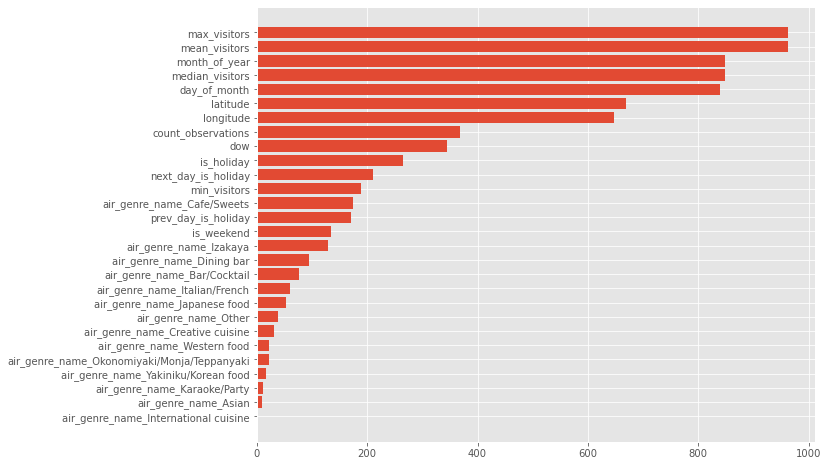

In [75]:

%matplotlib inline
# from matplotlib import style
import matplotlib.pyplot as plt
plt.style.use('ggplot') # これだとダークテーマでも目盛りが見える!

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot()
plt.rcParams["xtick.labelsize"] =10
plt.rcParams["ytick.labelsize"] =10
tmp = pd.DataFrame(index=X_test.columns)
tmp['importance'] = model.feature_importances_
tmp = tmp.sort_values('importance',ascending=True)
plt.barh(tmp.index,tmp.importance)
# plt.barh(tmp.importance,tick_label=tmp.index,height=80)

plt.show()

In [17]:
NOW = mpre2.mk_now()
NOW

'2021-08-15_19-12-55'

In [18]:
# missing_values_table(sub)
sub.to_csv(f'../../output/{NOW}.csv',index=False)
tmp = pd.read_csv(f'../../output/{NOW}.csv')
tmp

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,1.789109
1,air_00a91d42b08b08d9_2017-04-24,19.223714
2,air_00a91d42b08b08d9_2017-04-25,25.125930
3,air_00a91d42b08b08d9_2017-04-26,28.245374
4,air_00a91d42b08b08d9_2017-04-27,29.576618
...,...,...
32014,air_fff68b929994bfbd_2017-05-27,6.686792
32015,air_fff68b929994bfbd_2017-05-28,3.109213
32016,air_fff68b929994bfbd_2017-05-29,3.639789
32017,air_fff68b929994bfbd_2017-05-30,4.346518


In [ ]:

# submitのヘッダー情報
missing_values_table(submit)

Your selected dataframe has 2 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
visitors,341,1.1


# 検証コード

<AxesSubplot:ylabel='Frequency'>

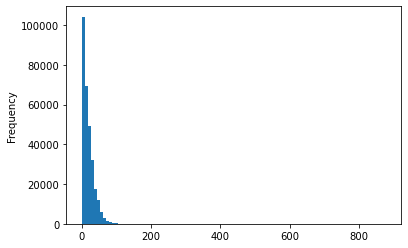

In [ ]:
# 売り上げが正規分布に従っているか検証、１店舗ごとにプロットすると正規分布に従うことがわかる
tmp = air_visit.query("air_store_id == 'air_00a91d42b08b08d9'")
# tmp['visitors'].plot.hist(bins=100)
# air_visit['visitors'].plot.hist(bins=100)

In [ ]:
cv.split(X_train, y_train)

In [ ]:
# hashlib.md5(b"1").digest()
import hashlib
# dat = frozenset(tuner_cv.best_params.items())
# SHA512のハッシュ値
# hs = hashlib.sha1()
hashlib.sha1(str(frozenset(tuner_cv.best_params.items())).encode().hexdigest())
# hs = hashlib.sha224(frozenset(tuner_cv.best_params.items()))
# hs = hashlib.sha224(dat.encode()).hexdigest()
# print(hs)
# dat


In [ ]:
# tuner_cv.best_score
# tuner_cv.best_params
# checkpoint_cb.cv_boosters[4115625917578661725]

len(checkpoint_cb.cv_boosters)
# len(tuner_cv.study.trials)
# checkpoint_cb.get_trained_model(tuner_cv.best_params)
# checkpoint_cb.cv_boosters.keys()
# # tuner_cv.best_params
# cv_booster = checkpoint_cb.get_trained_model(tuner_cv.best_params)


In [ ]:
'''GW中の移動平均を観察 見た感じ2016,2017のGWは祝日フラグを立ててもよさそう
is_holidayに代入するかと思ったけどすでにしてあった'''
# クエリが意図したとおりに動作しなかったのでクエリなしで
# tmp.query("visit_date2 > '2016-03-28'" and "visit_date2 < '2016-05-28'")

tmp = avd.groupby('visit_date').agg({'visitors': 'mean'})
tmp = tmp.query("index > '2016-03-28'" and "index < '2016-05-28'")
# print(tmp)
tmp['visit_date2'] = tmp.index
tmp['visit_date2'] = pd.to_datetime(tmp['visit_date2'])
tmp['visit_dateint'] = tmp['visit_date2'].astype(np.int64)
# 移動平均
window = 7
tmp["visitors_7"] = tmp["visitors"].rolling(window).mean()

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=[12, 9]
fig1 = plt.figure(1)
################################
#1つ目のウィンドウ 1つ目のグラフ
################################
ax1 = fig1.add_subplot(211)
# plt.plot(tmp.visit_dateint, tmp.visitors_7)
plt.plot(tmp.visit_dateint, tmp.visitors)

plt.minorticks_on(); plt.grid(True, which='both') # whichがbothなので主目盛り副目盛り両方グリッド線を描画
p = plt.vlines([1461888000000000000], 10, 40, "blue", linestyles='dashed') # GW
p = plt.vlines([1462665600000000000], 10, 40, "blue", linestyles='dashed') # GW
p = plt.vlines([1462147200000000000], 10, 40, "red", linestyles='dashed') # GWだが5/2で平日
p = plt.vlines([1462492800000000000], 10, 40, "red", linestyles='dashed') # GWだが5/6で平日
# 2016
# 4月29日（金・祝）昭和の日
# 4月30日（土）
# 5月1日 （日）
# 5月2日 （月）平日
# 5月3日 （火・祝）憲法記念日
# 5月4日 （水・祝）みどりの日
# 5月5日 （木・祝）こどもの日
# 5月6日 （金）平日
# 5月7日（土）
# 5月8日（日）

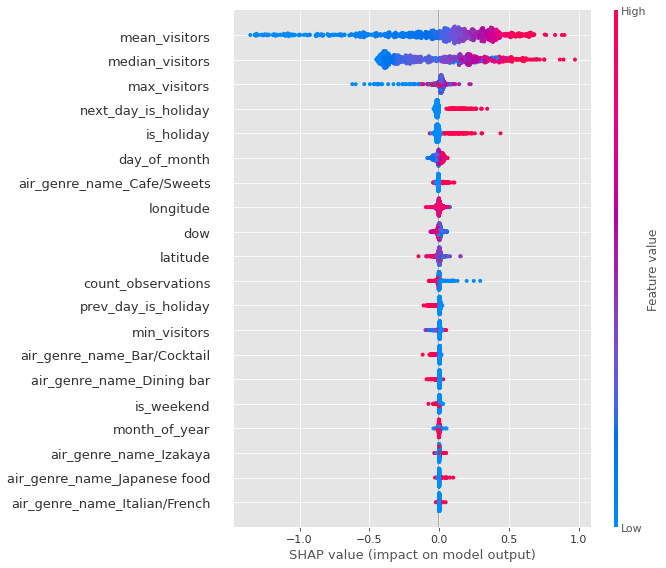

In [76]:
%matplotlib inline
import shap
shap.initjs()
X_test = shap.sample(X_test, 1000)
explainer = shap.TreeExplainer(model, data=X_test)
# Consider using shap.sample(data, 100) to create a smaller background data set.

# そして、TreeExplainer を使って、モデルがどのように推論するか解釈したいデータについて SHAP Value を計算しよう。
# この SHAP Value は、入力したのと同じ次元と要素数で得られる。 そして、値が大きいほど推論において影響が大きいと見なすことができる。
tr_x_shap_values = explainer.shap_values(X_test)
# つまり、行方向に見れば「特定の予測に、それぞれの特徴量がどれくらい寄与したか」と解釈できる。 
# 同様に、列方向に見れば「予測全体で、その特徴量がどれくらい寄与したか」と解釈できる。

# SHAP Value は自分で可視化しても良いけど、組み込みでいくつかグラフを描画する仕組みが用意されている。 ここからは、それらを使い分けなどと共に見ていこう。
# Summary Plot
# はじめに、Summary Plot から。 このグラフは、デフォルトでは特徴量ごとに SHAP Value を一軸の散布図として描画する。

shap.summary_plot(shap_values=tr_x_shap_values,
                  features=X_test,
                  feature_names=X_test.columns)


In [ ]:
mean
median
max